In [85]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as plt
import math
from glob import glob
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def to_screen(name, file):
    cv.imshow(name, file)  
    cv.waitKey(0)
    cv.destroyAllWindows()  

# Exercise 1 

### Assignment 1: filterbank of DoG filters
TODO: vanaf dog2 in een hulp functie steken

In [59]:
def create_and_show_dog(angle, dog_filters, scale):
    semi_scale = scale//2
    sigma = 0.3*((scale-1)*0.5 - 1) + 0.8

    ### step 1
    # Creates a 1-D Gaussian kernel 
    kernel = cv.getGaussianKernel(scale, sigma, cv.CV_32F)
    square = np.zeros((scale,scale), dtype="float32")
    square[semi_scale,:] = kernel.flatten()

    ### step 2
    kernel2 = cv.getGaussianKernel(scale, sigma-1, cv.CV_32F)
    filter = cv.filter2D(square, -1, kernel2)

    ### create Sobel filter
    dog = cv.Sobel(filter, cv.CV_32F, 0, 1, ksize=3)
    rows,cols = dog.shape

    M = cv.getRotationMatrix2D((semi_scale, semi_scale), angle, 1)
    new_dog = cv.warpAffine(dog, M, (cols,rows))
    ax = sns.heatmap(new_dog)
    plt.show()
    dog_filters.append(new_dog)

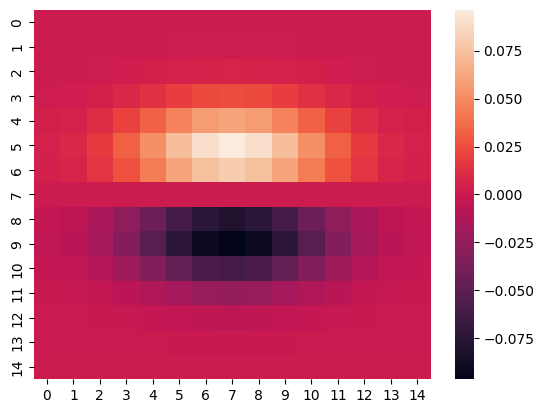

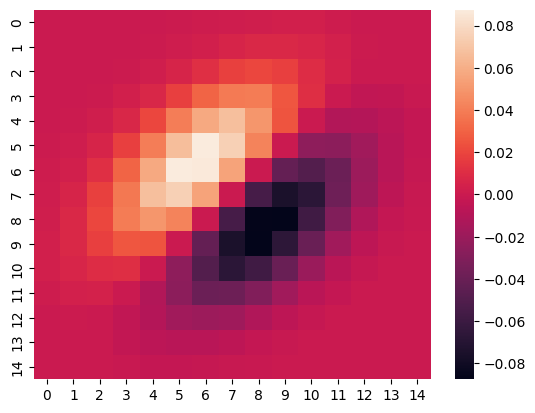

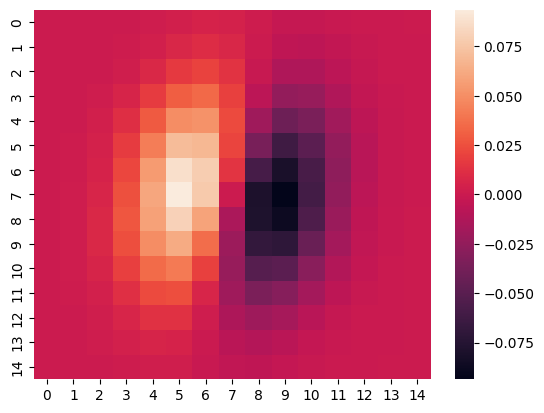

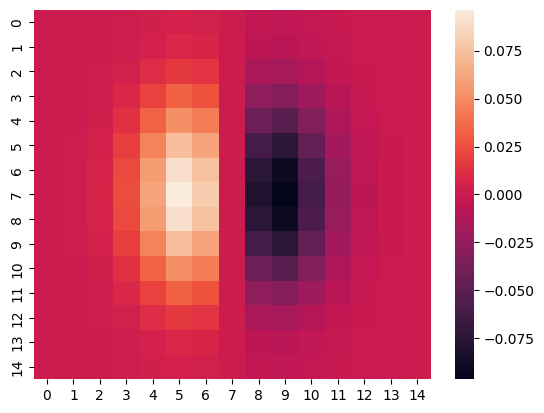

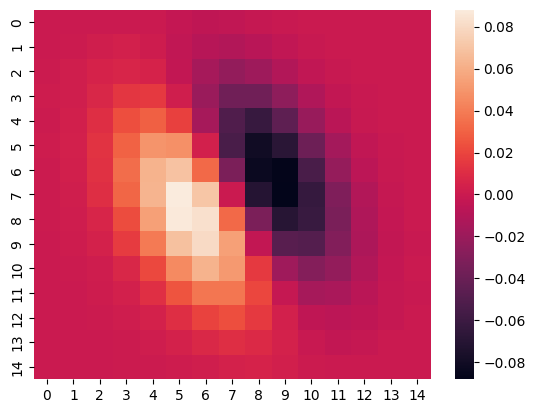

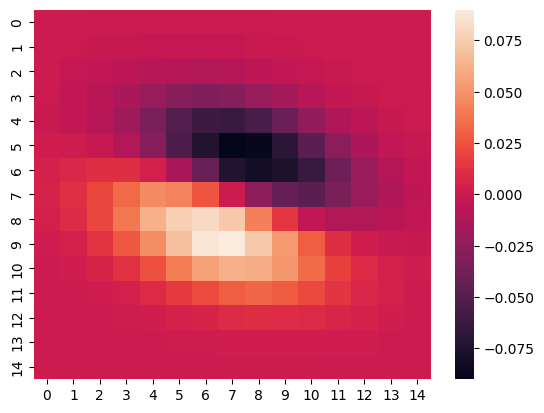

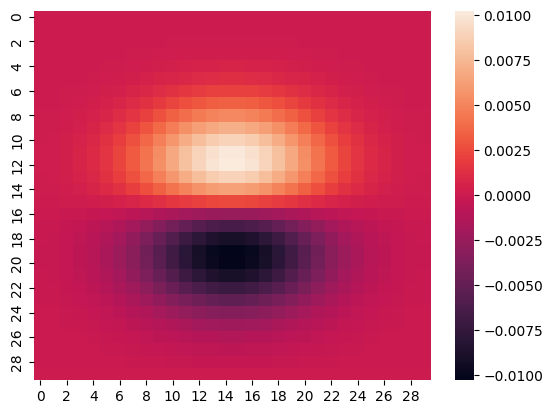

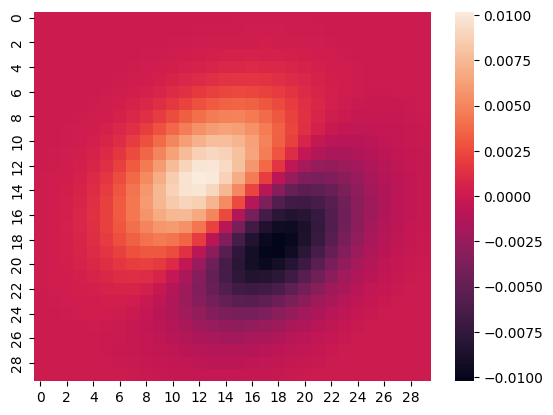

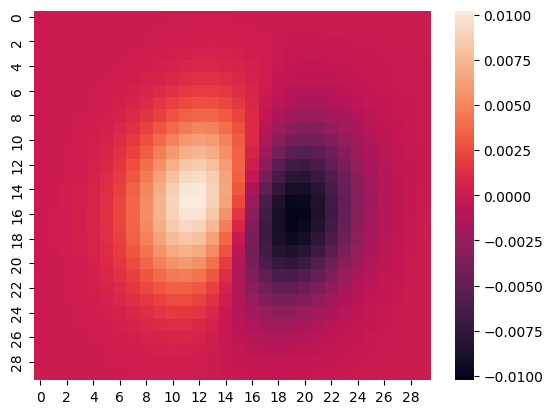

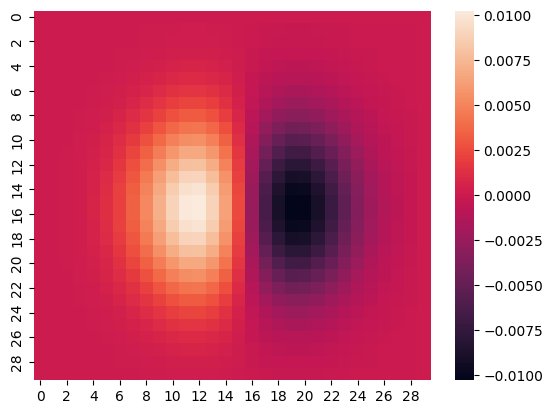

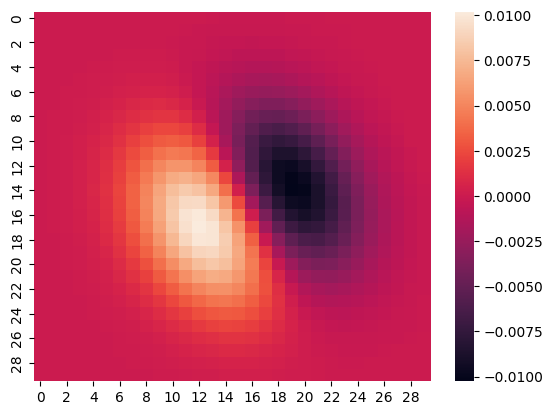

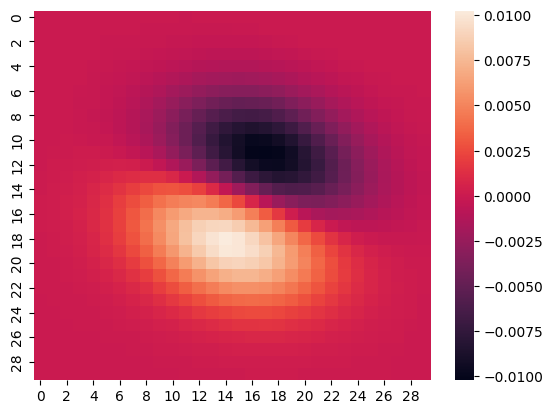

In [61]:
# list to store all dog filters
dog_filters = []

scales = [15, 30]
angles = [0, 45, 80, 90, 115, 160]

for j in range(len(scales)):
    for i in range(len(angles)):
        create_and_show_dog(angles[i], dog_filters, scales[j])

### Assignment 2

In [191]:
import copy

sources = sorted(glob("../afbeeldingen/road?.png"))
labels = sorted(glob("../afbeeldingen/road?_skymask.png"))

features = np.array([])
values = np.array([])

for source, label in zip(sources, labels):
    im = cv.imread(source, 1)
    lab = cv.imread(label, 0)

    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    gray_float = gray.astype("float32")
    new_img = copy.deepcopy(im)

    for filter in dog_filters:
        filtered = cv.filter2D(gray_float, -1, filter, borderType=cv.BORDER_DEFAULT)
        # append the filter response to the feature vector
        # 352x640x3 image en 352x640 response, eerst response uitbreiden naar 352x640x1
        # dan appenden zodat je 352x640x4, 352x640x5 etc krijgt
        new_img = np.append(new_img, np.expand_dims(filtered, -1), axis=-1)

    values = np.append(values, lab)
    features = np.append(features, new_img)       

In [192]:
features = np.reshape(features, (values.shape[0], -1))
print(f"shape of feature vector: {features.shape}")

shape of feature vector: (450560, 15)


In [193]:
# this discards any pixel with value not 0 or 255 from the arrays for training
which = np.union1d(np.where(values == 255), np.where(values == 0))
features = features[which, :]
values = values[which]


# initialize and train a QDA classifier
qda = QuadraticDiscriminantAnalysis()
qda.fit(features, values)
print(f'Mean training accuracy: {qda.score(features, values)}')

Mean training accuracy: 0.9941927020904656


In [181]:
import copy

# test the trained model
for source in sources:
    im = cv.imread(source, 1)
    filtered_image = copy.deepcopy(im)

    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    gray_float = gray.astype("float32")

    for filter in dog_filters:
        filtered = cv.filter2D(gray_float, -1, filter)
        # append the filter response to the feature vector
        filtered_image = np.append(filtered_image, np.reshape(filtered, (filtered.shape[0], filtered.shape[1], 1)), axis=2)
    
    # convert to a Kx15 array that has all the pixels as rows
    im_2d = np.reshape(filtered_image, (filtered_image.shape[0] * filtered_image.shape[1], -1))

    plab = qda.predict(im_2d)
    # return to original image dimensions for visualization
    plab = np.reshape(plab, (filtered_image.shape[0], filtered_image.shape[1]))
    plab_color = cv.merge((np.zeros(plab.shape, float), (plab == 255).astype(float), (plab == 0).astype(float)))

    cv.namedWindow("predicted data")
    cv.imshow("predicted data", 0.7 * im / 255 + 0.3 * plab_color)
    cv.waitKey()
    cv.destroyWindow("predicted data")

# Excercise 2

### Assignment 3: Random forest
pay attention to:
* the __number of decision trees__, controlling the overall complexity of the classifier (related to the complexity of the data),
* the __minimum leaf size__, which controls how many samples must be grouped together as a minimum at 
the end of each decision tree (usually specified as a fraction of the total data).

In [194]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# min_samples_leaf => minimum leaf size
# n_estimators => number of trees
param_grid = {
    'min_samples_leaf': [1, 4, 16],
    'n_estimators': [10, 50, 100],
}


# initialize and train a Random Forest classifier
rfc = RandomForestClassifier()

# using gridsearch to find optimal parameters
grid_search = GridSearchCV(rfc, param_grid)

grid_search.fit(features, values)

# Print the best hyperparameters and accuracy score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.4f}")

KeyboardInterrupt: 